# This notebook is initially started by using examples from this [GitHub project](https://github.com/benmoseley/harmonic-oscillator-pinn).


In [28]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pinns import *

### The solution of the ODE of damped harmonic oscillator
<h2><center>$ m\frac{d^2 x}{d t^2} + \mu \frac{d x}{d t} + k  = 0,$</center></h2>

### is
<h2><center>$ x(t) = C_1 e^{\lambda_1 t} + C_2 e^{\lambda_2 t},$</center></h2>

### where
<h2><center>$ \lambda_{1,2} = -d \pm \sqrt{d^2 - \omega_9^2},$</center></h2>

### and
<h2><center>$ d = \frac{\mu}{2m}, \quad \omega_0 = \sqrt{\frac{k}{m}}.$</center></h2>

### We first solve the ODE analytically first with Parameters:  $d  = 2$, $\omega_0 = 20$ and plot it for a duration equal to a unit of time.

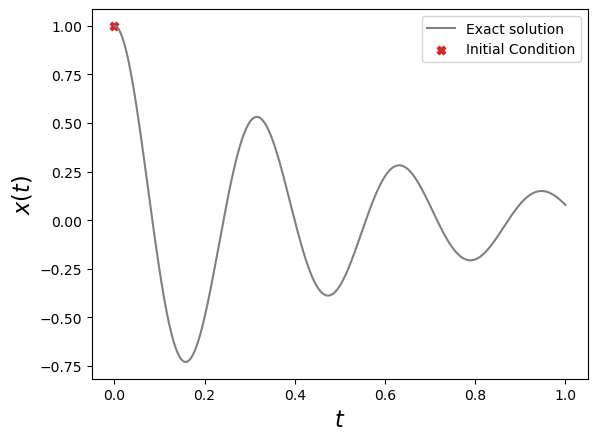

In [60]:
d, w0 = 2, 20

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)    
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

# get the analytical solution over the full domain
t = torch.linspace(0,1,500).view(-1,1)
x = oscillator(d, w0, t).view(-1,1)

plt.figure()
plt.plot(t, x, color="grey", label="Exact solution")
plt.scatter(0, 1, marker='X', color="tab:red", label="Initial Condition")
plt.xlabel(r"$t$", fontsize=16);plt.ylabel(r"$x(t)$", fontsize=16)
plt.legend()
plt.show()

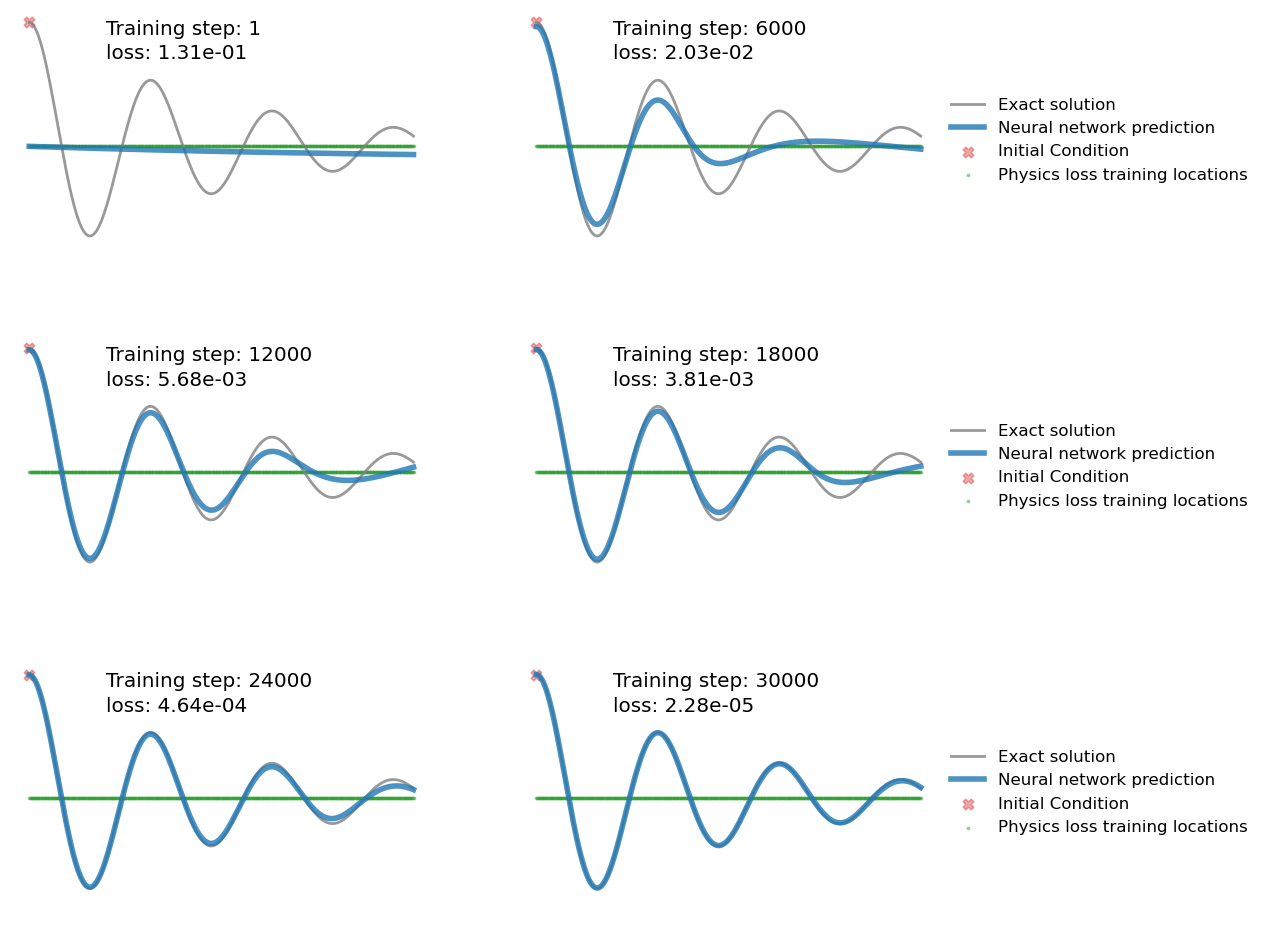

In [66]:
def plot_result(ax, ax_index, epoch, 
                x,y,
                x_init,y_init,
                xh,yh):    
            
    ax.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    ax.plot(xh,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    ax.scatter(x_init, y_init, s=60, marker="X", color="tab:red", alpha=0.4, label='Initial Condition')
    ax.scatter(xh, -0*torch.ones_like(xh), s=3, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    if ax_index%2 == 0:
        l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-1.1, 1.1)
    plt.text(0.2,0.9,f"Training step: {(i+1)}",fontsize="x-large",color="k")
    plt.text(0.2,0.7,f"loss: {np.mean(((y-yh).numpy())**2):.2e}",fontsize="x-large",color="k")
    plt.axis("off")

# Get damping coefficient, mu, and the spring constant, k,from the given parameters
mu, k = 2*d, w0**2
# Initial conditions: x'(0), x(0)
d_x_t_0, x_t_0, t_0 = torch.tensor([0.]), torch.tensor([1.]), torch.tensor([0.]).requires_grad_(True)
# Locations over the problem domain
t_physics = torch.linspace(0,1,500).view(-1,1).requires_grad_(True)
#
torch.manual_seed(42)
# Define the mneural net modeland the optimizer
model = Net_dense([1,32,32,32,1])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
# Output figure
fig = plt.figure(figsize=(12, 12))
ax_index = 1 # ploting figure index
#
epochs = 30000
for i in range(epochs):
    optimizer.zero_grad()
    
    # compute the "data loss" at initial conditionor x(t=0)
    x_t_0_hat = model(t_0)
    # L2 or mean squared error
    loss1 = torch.mean((x_t_0_hat-x_t_0)**2)
    # computes dx/dt at t=0
    d_x_t_0_hat  = torch.autograd.grad(x_t_0_hat, t_0, torch.ones_like(x_t_0_hat), create_graph=True)[0]
    loss2 = (1e-1)*(d_x_t_0_hat - d_x_t_0)**2
    # compute the "physics loss"
    x_hat = model(t_physics)
    # computes dx/dt
    dx_hat  = torch.autograd.grad(x_hat, t_physics, torch.ones_like(x_hat), create_graph=True)[0]
    # computes d^2x/dt^2
    dx2_hat = torch.autograd.grad(dx_hat,  t_physics, torch.ones_like(dx_hat),  create_graph=True)[0]
    # computes the residual of the 1D harmonic oscillator differential equation
    physics = dx2_hat + mu*dx_hat + k*x_hat
    loss3 = (1e-4)*torch.mean(physics**2)
    

    
    # backpropagate joint loss
    loss = loss1 + loss2 + loss3 # add three loss terms together
    loss.backward()
    optimizer.step()
    # plot the result as training progresses
    if ((i+1) % (epochs//5) == 0 or i==0) and ax_index <= 6: 
        x_hat = model(t_physics).detach()
        
        ax = plt.subplot(3,2,ax_index)
        plot_result(ax, ax_index, i, 
                    t,x,
                    t_0.detach(),x_t_0.detach(),
                    t_physics.detach(),x_hat.detach())
        ax_index += 1
        